In [1]:
from datasets import load_dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,balanced_accuracy_score
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Subset
from transformers import EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold 
import numpy as np
from datasets import Dataset, DatasetDict, ClassLabel
from nltk.tokenize import sent_tokenize


/home/elson/factcheck/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!nvidia-smi

Fri Apr 12 15:00:42 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:61:00.0 Off |                    0 |
| N/A   38C    P0    55W / 300W |   3333MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:62:00.0 Off |                    0 |
| N/A   

In [3]:
from datasets import load_dataset

# Load the dataset from the CSV file
dataset = load_dataset(
    'csv',
    data_files='dataset_semanticattribution_nerfeatures_modified.csv',
    delimiter=',',
    column_names=[
        "claim", "premise", "label", "category", "count_bf", "count_ca", "count_dis",
        "count_food", "count_lipid", "count_treat", "pres_bf", "pres_ca", "pres_dis",
        "pres_food", "pres_lipid", "pres_treat", "counte_bf", "counte_ca", "counte_dis",
        "counte_food", "counte_lipid", "counte_treat", "prese_bf", "prese_ca", "prese_dis",
        "prese_food", "prese_lipid", "prese_treat", "url", "entities", "entity_map",
        "gold_exp", "gemini_exp", "gemini_label","entity_ev","entity_map_ev", "split"
    ],
    skiprows=1
)

# Assuming 'split' column contains strings 'train', 'validation', 'test'
# Filter the loaded dataset into subsets
train_dataset = dataset['train'].filter(lambda example: example['split'] == 'train')
validation_dataset = dataset['train'].filter(lambda example: example['split'] == 'validation')
test_dataset = dataset['train'].filter(lambda example: example['split'] == 'test')

Using custom data configuration default-3c9b2ca84604c57f
Reusing dataset csv (/home/elson/.cache/huggingface/datasets/csv/default-3c9b2ca84604c57f/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58)
100%|██████████| 1/1 [00:00<00:00, 206.33it/s]
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-3c9b2ca84604c57f/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-0fe5b9ad8f7c7cc3.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-3c9b2ca84604c57f/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-1bcc19add96e57df.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-3c9b2ca84604c57f/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-4d1531b21b696f09.arrow


In [4]:
train_dataset

Dataset({
    features: ['claim', 'premise', 'label', 'category', 'count_bf', 'count_ca', 'count_dis', 'count_food', 'count_lipid', 'count_treat', 'pres_bf', 'pres_ca', 'pres_dis', 'pres_food', 'pres_lipid', 'pres_treat', 'counte_bf', 'counte_ca', 'counte_dis', 'counte_food', 'counte_lipid', 'counte_treat', 'prese_bf', 'prese_ca', 'prese_dis', 'prese_food', 'prese_lipid', 'prese_treat', 'url', 'entities', 'entity_map', 'gold_exp', 'gemini_exp', 'gemini_label', 'entity_ev', 'entity_map_ev', 'split'],
    num_rows: 1623
})

In [5]:
dataset = DatasetDict({
    'train': train_dataset,
    'val': validation_dataset,
    'test': test_dataset
})

In [6]:
columns_to_keep = ['claim', 'premise', 'label','category','entity_map','entity_map_ev']
all_columns = train_dataset.column_names

columns_to_drop = [col for col in all_columns if col not in columns_to_keep]
for split in dataset.keys():
    dataset[split] = dataset[split].remove_columns(columns_to_drop)

In [7]:
from datasets import load_dataset, DatasetDict

label2id = {
    "contradiction": 1,
    "entailment": 0,
    "neutral": 1
}

id2label = {v: k for k, v in label2id.items()}

label_mapping = {
    'SUPPORTED': 'entailment',
    'REFUTED': 'contradiction',
    'NOT ENOUGH INFORMATION': 'neutral'
}

def map_and_encode_labels(example):
    # Map original dataset labels to new labels ('entailment', 'contradiction', 'neutral')
    mapped_label = label_mapping[example['label']]
    # Encode mapped labels using label2id
    example['label'] = label2id[mapped_label]
    return example

for split in dataset.keys():
    dataset[split] = dataset[split].map(map_and_encode_labels)


# Show the label encoding mapping
print("Label Encoding Mapping:", label2id)

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-3c9b2ca84604c57f/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-0610e61362040638.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-3c9b2ca84604c57f/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-0f333229cd0c2dcd.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-3c9b2ca84604c57f/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-a87677da2d8a9947.arrow


Label Encoding Mapping: {'contradiction': 1, 'entailment': 0, 'neutral': 1}


In [8]:
dataset['val']['entity_map']

['vldl is a lipid. triglycerides is a lipid.',
 'syncope is a disease.',
 None,
 'strokes is a disease.',
 'stroke is a disease.',
 None,
 None,
 None,
 'thyroid disease is a disease. medication is a treatment.',
 'thyroid disease is a disease.',
 None,
 None,
 'tamoxifen is a treatment. breast cancer is a disease.',
 None,
 'syncope is a disease.',
 "parkinson's tremors is a disease.",
 'ldl is a lipid. plaque is a disease.',
 None,
 None,
 'thyroid disease is a disease. stress is a causative agent.',
 None,
 'iv therapy is a treatment. infection is a disease.',
 'ldl is a lipid.',
 'stroke is a disease.',
 'diabetes is a disease.',
 'toenail fungus is a disease.',
 'thyroid disease is a disease.',
 None,
 'heart disease is a disease.',
 None,
 'pcsk9 inhibitors is a treatment. ldl is a lipid. vldl is a lipid.',
 'tooth decay is a disease.',
 'varicose veins is a disease.',
 None,
 None,
 'pcsk9 inhibitors is a treatment. ldl is a lipid. vldl is a lipid.',
 None,
 'ldl is a lipid.',
 

In [9]:
labels = np.array(dataset['train']['label'])

In [10]:
def replace_entity_map(example):
    if example['entity_map'] is None:
        example['entity_map'] = ''  # Replace None with an empty string
    return example

def replace_entity_map_ev(example):
    if example['entity_map_ev'] is None:
        example['entity_map_ev'] = ''  # Replace None with an empty string
    return example

# Apply the function to the dataset
dataset = dataset.map(replace_entity_map)
dataset = dataset.map(replace_entity_map_ev)

Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-3c9b2ca84604c57f/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-444d3ff8af4fa1ca.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-3c9b2ca84604c57f/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-15e734f31f71e3b0.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-3c9b2ca84604c57f/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-c5095ed2a4d43ad2.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-3c9b2ca84604c57f/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cache-ac32259621eada70.arrow
Loading cached processed dataset at /home/elson/.cache/huggingface/datasets/csv/default-3c9b2ca84604c57f/0.0.0/51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58/cach

In [11]:
dataset['val']['entity_map']

['vldl is a lipid. triglycerides is a lipid.',
 'syncope is a disease.',
 '',
 'strokes is a disease.',
 'stroke is a disease.',
 '',
 '',
 '',
 'thyroid disease is a disease. medication is a treatment.',
 'thyroid disease is a disease.',
 '',
 '',
 'tamoxifen is a treatment. breast cancer is a disease.',
 '',
 'syncope is a disease.',
 "parkinson's tremors is a disease.",
 'ldl is a lipid. plaque is a disease.',
 '',
 '',
 'thyroid disease is a disease. stress is a causative agent.',
 '',
 'iv therapy is a treatment. infection is a disease.',
 'ldl is a lipid.',
 'stroke is a disease.',
 'diabetes is a disease.',
 'toenail fungus is a disease.',
 'thyroid disease is a disease.',
 '',
 'heart disease is a disease.',
 '',
 'pcsk9 inhibitors is a treatment. ldl is a lipid. vldl is a lipid.',
 'tooth decay is a disease.',
 'varicose veins is a disease.',
 '',
 '',
 'pcsk9 inhibitors is a treatment. ldl is a lipid. vldl is a lipid.',
 '',
 'ldl is a lipid.',
 'wear and tear is a causative 

In [12]:
from transformers import AutoTokenizer
import torch.utils.data

class MediClaimDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer_name='MoritzLaurer/DeBERTa-v3-base-mnli-fever-docnli-ling-2c'):
        self.dataset = dataset
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        idx = int(idx)  # Ensure idx is an integer
        item = self.dataset[idx]  # Access the dataset item at idx
        
        # Extracting claim and evidence texts
        

        claim = item['claim']
        premise = item['premise'].replace('\n', '').replace('[','').replace(']','')
        sentences = sent_tokenize(premise)
        sep_token = ' [SEP] '
        premise = sep_token.join(sentences)
        ner_ev = sent_tokenize(item['entity_map_ev'])
        premise += sep_token + sep_token.join(ner_ev)
        
        ner = sent_tokenize(item['entity_map'])
    
        
        claim += sep_token + sep_token.join(ner)
              
        # Tokenize the texts
        inputs = self.tokenizer(
             premise, claim,
            return_tensors="pt",  # Ensure PyTorch tensors are returned
            padding='max_length',  # Apply padding to the maximum length
            truncation='longest_first',  # Truncate to the maximum length if necessary
            max_length=512,  # Specify the maximum length
            add_special_tokens=True  # Add special tokens like [CLS], [SEP]
        )
        
        item['input_ids'] = inputs['input_ids'].squeeze()  # Remove batch dimension
        item['attention_mask']= inputs['attention_mask'].squeeze() # Remove batch dimension
        
        output_item = {
            'input_ids': inputs['input_ids'].squeeze(),  # Remove batch dimension
            'attention_mask': inputs['attention_mask'].squeeze(),  # Remove batch dimension
            'claim': claim,  # Include augmented claim text
            'evidences': premise  # Include original evidence text
        }
        
        if 'label' in item:
            output_item['label'] = torch.tensor(item['label'], dtype=torch.long)
        
        return output_item




In [13]:
import torch
print(torch.cuda.device_count())
print("Available GPUs:")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

1
Available GPUs:
GPU 0: Tesla V100-SXM2-32GB


In [14]:
model_name = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-docnli-ling-2c"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                 num_labels=3, ignore_mismatched_sizes=True)
device = "cuda:0"
model = model.to(device)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at MoritzLaurer/DeBERTa-v3-base-mnli-fever-docnli-ling-2c and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
print(f"Model is on device: {next(model.parameters()).device}")

Model is on device: cuda:0


In [16]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average="weighted")  # Specify average method
    recall = recall_score(labels, preds, average="weighted")  # Specify average method

    bal_accuracy = balanced_accuracy_score(labels,preds)

    return {"accuracy": acc, "balanced_accuracy":bal_accuracy, "precision": prec, "recall": recall, "f1": f1}

In [17]:
dataset['train']

Dataset({
    features: ['claim', 'premise', 'label', 'category', 'entity_map', 'entity_map_ev'],
    num_rows: 1623
})

In [18]:
import gc

torch.cuda.set_device(0)

# Clearing the cache
torch.cuda.empty_cache()
gc.collect()
# Checking GPU memory, making sure to reset peak memory stats
torch.cuda.reset_peak_memory_stats()

In [19]:
current_device = torch.cuda.current_device()
print(f"Current CUDA device: GPU {current_device}")

Current CUDA device: GPU 0


In [20]:
train_data = dataset['train']
eval_data = dataset['val']
model = model.to('cuda:0')

In [21]:
tdata = MediClaimDataset(train_data)
vdata = MediClaimDataset(eval_data)
test_data = MediClaimDataset(dataset['test'])

In [22]:
tdata.__getitem__(0)

{'input_ids': tensor([     1,   2600,   3405,  94326,    261,   1149,    260,    346,  29597,
           1165,  32453,    261,    273,    260,    346,   2846,  91581,  94326,
            261,    916,    260,    346, 117259,  47587,    261,    749,    260,
            346,  10490,  73907,   2179,  32453,    261,   1130,    260,    346,
           1407,   3359,  73907,   2179,  32453,    261,    851,    260, 100066,
            263,  98237,   1830,   6725,    263,   5134,  30055,  77487,    532,
           4014,    271,    547,  52263,  16224,    265,  86207,  14178,    268,
            260,  97818,   4379,    261,    273,    260,  43923,  23399,    429,
           8068,   1068,    268,    265,  88327,   1917, 110269,    287,    260,
          57909,   4765,  12100,   2148,    263,  25348,  20413,   1563,    265,
            917,    263,    308,    266,  84530,  62542,    275,  98237,    287,
          41462,    667,  65073,  44845,  22317,    285,  36774,    260,  70298,
          40149

In [23]:
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments,DataCollatorWithPadding


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

device = torch.device("cuda:0")

training_args = TrainingArguments(
    output_dir=f'/home/elson/5.2.6_deberta/',
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    dataloader_pin_memory=True,
    dataloader_num_workers=4,
    fp16=True,
    warmup_ratio=0.06,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

trainer = Trainer(
    model=model.to("cuda:0"),
    args=training_args,
    train_dataset=tdata,
    eval_dataset=vdata,
    #tokenizer=tokenizer,
    #data_collator = data_collator,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)]
)
print(f"Model is on device: {next(model.parameters()).device}")
# Training and Evaluation
trainer.train()
eval_result = trainer.evaluate(vdata)

# Save the best model and tokenizer
model.save_pretrained(f'/home/elson/5.2.6_deberta/best_model')
tokenizer.save_pretrained(f'/home/elson/5.2.6_deberta/best_model')


Using amp half precision backend
/home/elson/factcheck/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1623
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2040


Model is on device: cuda:0


Epoch,Training Loss,Validation Loss,Accuracy,Balanced Accuracy,Precision,Recall,F1
1,0.527200,0.628403,0.711828,0.701292,0.738113,0.711828,0.719826
2,0.422400,0.663374,0.741935,0.707782,0.747209,0.741935,0.744224
3,0.292000,0.729728,0.722581,0.710994,0.746180,0.722581,0.729889
4,0.087300,1.431488,0.698925,0.697690,0.735406,0.698925,0.708680
5,0.122400,1.346293,0.679570,0.687500,0.728201,0.679570,0.691023
6,0.280000,1.522593,0.737634,0.714239,0.750244,0.737634,0.742289
7,0.049900,1.806630,0.720430,0.713266,0.747948,0.720430,0.728436
8,0.025000,1.778793,0.744086,0.726571,0.759789,0.744086,0.749436
9,0.007000,2.000289,0.739785,0.736857,0.767362,0.739785,0.747347
10,0.000400,2.196873,0.722581,0.714823,0.749237,0.722581,0.730404


***** Running Evaluation *****
  Num examples = 465
  Batch size = 16
Saving model checkpoint to /home/elson/5.2.6_deberta/checkpoint-102
Configuration saved in /home/elson/5.2.6_deberta/checkpoint-102/config.json
Model weights saved in /home/elson/5.2.6_deberta/checkpoint-102/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 465
  Batch size = 16
Saving model checkpoint to /home/elson/5.2.6_deberta/checkpoint-204
Configuration saved in /home/elson/5.2.6_deberta/checkpoint-204/config.json
Model weights saved in /home/elson/5.2.6_deberta/checkpoint-204/pytorch_model.bin
Deleting older checkpoint [/home/elson/5.2.6_deberta/checkpoint-102] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 465
  Batch size = 16
Saving model checkpoint to /home/elson/5.2.6_deberta/checkpoint-306
Configuration saved in /home/elson/5.2.6_deberta/checkpoint-306/config.json
Model weights saved in /home/elson/5.2.6_deberta/checkpoint-306/pytorch_model.bin
***** Running 

Configuration saved in /home/elson/5.2.6_deberta/best_model/config.json
Model weights saved in /home/elson/5.2.6_deberta/best_model/pytorch_model.bin
tokenizer config file saved in /home/elson/5.2.6_deberta/best_model/tokenizer_config.json
Special tokens file saved in /home/elson/5.2.6_deberta/best_model/special_tokens_map.json
added tokens file saved in /home/elson/5.2.6_deberta/best_model/added_tokens.json


('/home/elson/5.2.6_deberta/best_model/tokenizer_config.json',
 '/home/elson/5.2.6_deberta/best_model/special_tokens_map.json',
 '/home/elson/5.2.6_deberta/best_model/spm.model',
 '/home/elson/5.2.6_deberta/best_model/added_tokens.json')

In [24]:
model_path = "/home/elson/5.2.6_deberta/best_model/"
model = AutoModelForSequenceClassification.from_pretrained(model_path).to('cuda:0')

# Evaluate on the test set
test_results = trainer.predict(test_data)

loading configuration file /home/elson/5.2.6_deberta/best_model/config.json
Model config DebertaV2Config {
  "_name_or_path": "/home/elson/5.2.6_deberta/best_model/",
  "architectures": [
    "DebertaV2ForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-07,
  "max_position_embeddings": 512,
  "max_relative_positions": -1,
  "model_type": "deberta-v2",
  "norm_rel_ebd": "layer_norm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_dropout": 0,
  "pooler_hidden_act": "gelu",
  "pooler_hidden_size": 768,
  "pos_att_type": [
    "p2c",
    "c2p"
  ],
  "position_biased_input": false,
  "position_buckets": 256,
  "relative_atten

In [25]:
print(test_results)

PredictionOutput(predictions=array([[ 6.0391e+00,  1.4197e-01, -5.5859e+00],
       [ 6.2305e+00, -1.9421e-01, -5.4102e+00],
       [ 5.9219e+00, -2.2559e-01, -5.1953e+00],
       [-1.7139e+00,  7.2188e+00, -4.1953e+00],
       [ 3.0684e+00,  1.7793e+00, -4.3477e+00],
       [ 6.3555e+00, -5.8252e-01, -5.2305e+00],
       [ 6.4648e+00, -9.7949e-01, -4.9453e+00],
       [ 6.3008e+00, -6.0596e-01, -5.1953e+00],
       [ 6.4531e+00, -8.1836e-01, -5.0742e+00],
       [ 6.4336e+00, -8.0615e-01, -5.1133e+00],
       [ 6.2539e+00, -4.7949e-01, -5.2383e+00],
       [ 6.4141e+00, -6.9580e-01, -5.1953e+00],
       [ 6.3086e+00, -4.5557e-01, -5.2852e+00],
       [ 6.4102e+00, -7.4561e-01, -5.1602e+00],
       [ 3.5391e+00,  2.1973e+00, -5.0039e+00],
       [-8.5693e-01,  6.6797e+00, -4.6758e+00],
       [ 5.6133e+00,  1.0541e-01, -5.2109e+00],
       [ 5.6133e+00, -1.6235e-02, -5.1250e+00],
       [ 6.2461e+00, -4.9170e-01, -5.2539e+00],
       [ 6.4727e+00, -8.0762e-01, -5.1016e+00],
       [ 6.

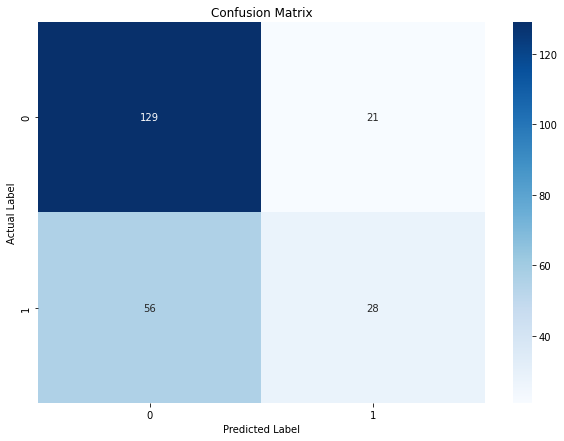

In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
probabilities = torch.softmax(torch.tensor(test_results.predictions).to(torch.float32), dim=-1)
predictions = np.argmax(probabilities.numpy(), axis=1)
true_labels = test_results.label_ids
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

In [27]:
import pandas as pd
data_to_save = []
for idx in range(len(test_data)):
    item = dataset['test'][idx]
    actual_label = item['label']
    predicted_label = predictions[idx]
    claim = item['claim'] 
    premise = item['premise'] 
    category = item['category']
    
    # Append the information as a dictionary to the list
    data_to_save.append({
        'Claim': claim,
        'Premise': premise,
        'Actual Label': actual_label,
        'Predicted Label': predicted_label,
        'Category' : category
    })

df = pd.DataFrame(data_to_save)

# Save the DataFrame to a CSV file
df.to_csv('/home/elson/results/5.2.6_results.csv', index=False)

In [28]:
# Calculate correctly classified instances
correctly_classified = df[df['Actual Label'] == df['Predicted Label']]

# Calculate misclassified instances
misclassified = df[df['Actual Label'] != df['Predicted Label']]

# Count the number of correctly classified and misclassified by category
correct_classification_counts = correctly_classified['Category'].value_counts()
misclassification_counts = misclassified['Category'].value_counts()

In [29]:
correct_classification_counts

General Health           35
Bone health              18
Fitness                  13
Cancer                   12
Cardiovascular Health    11
Diabetes                 10
Throat                    9
Neurological health       9
COVID                     6
Ear                       6
Skin                      6
Hair                      5
Women' s Health           4
Mental Health             3
Men's health              3
Blood                     3
Eye                       2
Muscles                   2
Name: Category, dtype: int64

In [30]:
misclassification_counts

Skin                     18
General Health           16
Hair                      7
Eye                       7
Blood                     6
Muscles                   4
Dental Health             3
Bone health               3
Men's health              3
Vascular                  3
Diabetes                  2
Women' s Health           2
Fitness                   2
Cardiovascular Health     1
Name: Category, dtype: int64